In [23]:
%%capture
!pip install geotiff-crop-dataset
!pip install rasterio

In [24]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import rasterio
from rasterio.warp import transform
import copy
import zipfile
import os
import numpy as np
import re
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt


# Extract the files

In [26]:
# Specify the path to the zip file
zip_file_pathCoordinates = "/content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/CoordinatesPoints/1MilCoordinatesMLTRANS_Redux.zip"
zip_file_pathElevation = "/content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/TifFilesRaster/Elevation_Redux.zip"
zip_file_pathLAI = "/content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/TifFilesRaster/LAI_2015_Redux.zip"
zip_file_LST = "/content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/TifFilesRaster/LST_2015_Redux.zip"
zip_file_pathMODIS_NPP_2015 = "/content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/TifFilesRaster/MODIS_NPP_2015_Redux.zip"
zip_file_PML = "/content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/TifFilesRaster/TotalEvapo_2015_Redux.zip"
zip_file_Es = "/content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/TifFilesRaster/SoilEvaporation_2015_Redux.zip"

In [27]:

# Function to extract all elements from a zip file
def extract_zip_file(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_file_name = os.path.basename(zip_file_path)
        zip_file_name_without_extension = os.path.splitext(zip_file_name)[0]
        zip_ref.extractall("/content/"+zip_file_name_without_extension)

# Call the function to extract all elements from the zip file
extract_zip_file(zip_file_pathElevation)
extract_zip_file(zip_file_pathCoordinates)
extract_zip_file(zip_file_pathMODIS_NPP_2015)


In [28]:
extract_zip_file(zip_file_pathLAI)
extract_zip_file(zip_file_LST)
extract_zip_file(zip_file_PML)
extract_zip_file(zip_file_Es)

# Sample Coordinates

In [29]:
eu_countries = [ # list of EU countries in the LUCAS SOIL dataset
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Denmark',
    'Estonia', 'France', 'Germany', 'Greece','United Kingdom' ,'Hungary', 'Czechia', 'Ireland', 'Italy', 'Latvia', 'Finland',
    'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania',
    'Slovakia', 'Slovenia', 'Spain', 'Sweden'
]

eu_countries_landArea = np.array([83871,30688,110994,56594,9251,42952,
                         45339,551695,357588,131957,243610,93026,78867,84421,302073,64589,338462,
                         65300,2586,316,41850,322575,92152,238397,
                         49035,20273,505990,528447])

percentages = (eu_countries_landArea / np.sum(eu_countries_landArea))

eu_dict = {country: percentage for country, percentage in zip(eu_countries, percentages)}
print(eu_dict)

{'Austria': 0.018667461402417772, 'Belgium': 0.006830335342578443, 'Bulgaria': 0.02470432224368325, 'Croatia': 0.01259632424328351, 'Cyprus': 0.002059027380545919, 'Denmark': 0.009559976656492091, 'Estonia': 0.01009125958345816, 'France': 0.12279268302997308, 'Germany': 0.0795896100913041, 'Greece': 0.02937013037019759, 'United Kingdom': 0.05422112854554009, 'Hungary': 0.020705121727668866, 'Czechia': 0.01755370364517512, 'Ireland': 0.018789876823377696, 'Italy': 0.0672334426465947, 'Latvia': 0.014375799317055495, 'Finland': 0.07533266947079591, 'Lithuania': 0.014534049070332778, 'Luxembourg': 0.0005755750520042965, 'Malta': 7.033322367879262e-05, 'Netherlands': 0.009314700667586934, 'Poland': 0.07179664439299535, 'Portugal': 0.020510592495088915, 'Romania': 0.05306085292833267, 'Slovakia': 0.010913891212308848, 'Slovenia': 0.004512232416582793, 'Spain': 0.1126199615482034, 'Sweden': 0.11761829447274343}


In [30]:
import os

directory = '/content/1MilCoordinatesMLTRANS_Redux/'

# Initialize an empty dictionary to store the results
subfolder_arrays = {}

# Iterate over subfolders in the directory
for subdir in os.listdir(directory):
    subfolder_path = os.path.join(directory, subdir)
    print(subdir)
    if subdir == ".config" or subdir == ".ipynb_checkpoints":
      continue
    # Check if the subfolder is a directory
    if os.path.isdir(subfolder_path):
        arrays = []

        # Iterate over files in the subfolder
        for file in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file)

            # Check if the file is a .npy file
            if os.path.isfile(file_path) and file.endswith('.npy'):
                # Load the .npy file as a NumPy array
                array = np.load(file_path)

                # Append the array to the arrays list
                arrays.append(array)

        # Concatenate all arrays in the subfolder into a single NumPy array
        subfolder_arrays[subdir] = np.concatenate(arrays, axis=0)

# Print the dictionary of subfolder arrays
for subdir, array in subfolder_arrays.items():
    print(subdir, "-", array)


France
Estonia
Germany
Portugal
.ipynb_checkpoints
Latvia
United Kingdom
Netherlands
Croatia
Luxembourg
Finland
Malta
Ireland
Slovenia
Cyprus
Romania
Lithuania
Belgium
Italy
Greece
Denmark
Poland
Czechia
Sweden
Hungary
Slovakia
Spain
Bulgaria
.config
France - [[ 1.30864938 44.987418  ]
 [-1.31286863 43.22488947]
 [ 7.37752727 43.89432073]
 ...
 [ 6.39937749 45.53769444]
 [ 4.75069342 47.32031439]
 [-0.48212455 45.87788335]]
Estonia - [[27.05290488 58.7081071 ]
 [27.48965426 57.72583057]
 [22.60235566 58.42842974]
 ...
 [27.3377961  58.00458868]
 [25.53044093 58.20630862]
 [25.12360316 58.46946956]]
Germany - [[ 8.61612718 50.72460222]
 [14.6775815  51.4877432 ]
 [ 6.27165892 51.78310846]
 ...
 [11.27948177 47.9659608 ]
 [ 9.93143633 48.28578102]
 [10.95376125 53.11702521]]
Portugal - [[-8.88905168 38.67689395]
 [-7.02826307 40.23287909]
 [-8.74529308 41.81618456]
 ...
 [-7.97329754 41.51796822]
 [-8.22996805 41.28835722]
 [-8.53992111 37.77518679]]
Latvia - [[22.29337438 56.58901409]
 

In [31]:

# Assuming you have the 'eu_dict' and 'subfolder_arrays' dictionaries defined

# Get the list of countries and their corresponding percentages
countries = list(eu_dict.keys())
percentages = list(eu_dict.values())

# Calculate the number of samples for each country based on the percentages
num_samples = np.round(np.array(percentages) * 1000000).astype(int)

# Initialize an empty array to store the sampled coordinates
sampled_coordinates = np.empty((0, 2), dtype=np.float64)

# Iterate over the countries and sample coordinates for each country
for country, num_sample in zip(countries, num_samples):
    if country in subfolder_arrays:
        coordinates = subfolder_arrays[country]
        indices = np.random.choice(range(len(coordinates)), size=num_sample, replace=False)
        sampled_coordinates = np.vstack((sampled_coordinates, coordinates[indices]))

# Print the shape of the sampled_coordinates array
print(sampled_coordinates.shape)


(981333, 2)


In [32]:
sampled_coordinates

array([[ 4.82271693, 50.18579929],
       [ 4.848174  , 50.60433986],
       [ 3.61299338, 51.09026832],
       ...,
       [20.21689089, 64.60361847],
       [19.21407584, 65.125579  ],
       [19.68903838, 65.94868868]])

In [33]:
# np.random.shuffle(sampled_coordinates)


# See the tif files of Evapo

In [34]:
import os
import rasterio

def check_same_values(raster_path):
    with rasterio.open(raster_path) as dataset:
        first_value = dataset.read(1)[0, 0]
        for i in range(1, dataset.count + 1):
            current_array = dataset.read(i)
            if not (current_array == first_value).all():
                return False
    return True

folder_path = '/content/TotalEvapo_2015_Redux/TotalEvapov2'
tif_files = [file for file in os.listdir(folder_path) if file.endswith('.tif')]

files_with_same_values = []
for tif_file in tif_files:
    tif_path = os.path.join(folder_path, tif_file)
    if check_same_values(tif_path):
        files_with_same_values.append(tif_file)

print("Files with the same value on all raster data:")
for file_name in files_with_same_values:
    print(file_name)


Files with the same value on all raster data:
ID474N34_13646201784612S32_339144865044645W-12_577032107816352E-10_776000087268802.tif
ID571N57_49365622187711S55_6921770601298W5_38619850241133E7_187230522958881.tif
ID400N43_122239331905796S41_320760170158486W-12_577032107816352E-10_776000087268802.tif
ID499N34_13646201784612S32_339144865044645W28_743392706442318E30_54442472698987.tif
ID21N71_86923512079426S70_06775595904695W3_5923726467560626E5_393404667303614.tif
ID237N34_13646201784612S32_339144865044645W16_16580167212627E17_966833692673823.tif
ID363N46_714053052162164S44_912573890414855W-8_985218387559982E-7_1841863670124315.tif
ID227N64_68144567133568S62_87996650958837W-3_595416802702511E-1_79438478215496.tif
ID342N71_86923512079426S70_06775595904695W8_982174231613534E10_783206252161085.tif
ID578N70_07124725619315S68_26976809444584W-5_393404667303614E-3_5923726467560626.tif
ID467N64_68144567133568S62_87996650958837W3_5923726467560626E5_393404667303614.tif
ID415N34_13646201784612S32_3

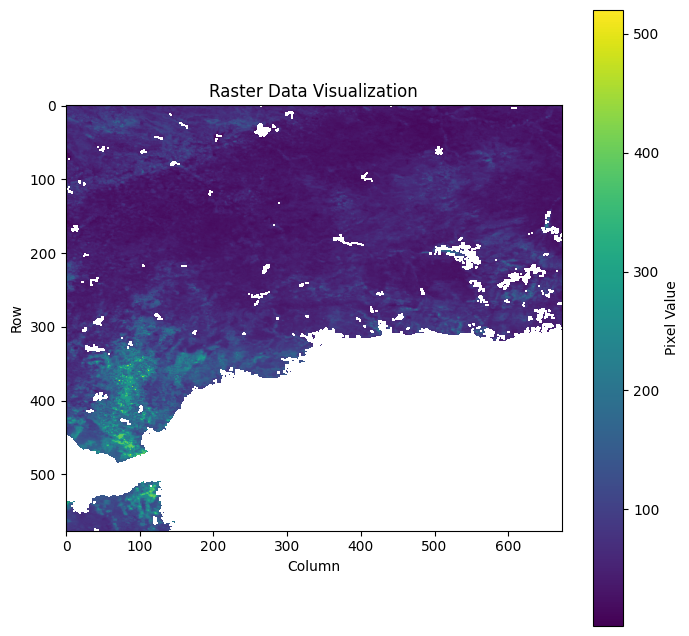

In [35]:
import rasterio
import matplotlib.pyplot as plt

file_path = '/content/TotalEvapo_2015_Redux/TotalEvapov2/ID100N37_73243774704832S35_93095858530101W-5_393404667303614E-3_5923726467560626.tif'
with rasterio.open(file_path) as dataset:
    raster_data = dataset.read(1)  # Read the first band

plt.figure(figsize=(8, 8))
plt.imshow(raster_data, cmap='viridis')
plt.colorbar(label='Pixel Value')
plt.title('Raster Data Visualization')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()


# Making the Bounds

In [36]:

def build_kdtree_from_npy_file(file_path):
    # Load data from .npy file
    data = np.load(file_path)

    # Extract longitude and latitude columns
    longitude = data[:, 1]
    latitude = data[:, 2]

    # Build KD-tree
    tree = cKDTree(np.column_stack((longitude, latitude)))

    return tree

def find_closest_indices(tree, query_point, k=4):
    # Query the tree for k nearest neighbors
    distances, indices = tree.query(query_point, k=k)

    return indices


In [37]:
import os
import re
import numpy as np
import rasterio

# Folder containing .tif files
tif_folder = '/content/LAI_2015_Redux/LAI2015v2'

# Output .npy file
npy_file = 'output.npy'

# List to store data
data_list = []

# Iterate through .tif files in the folder
for filename in os.listdir(tif_folder):
    if filename.endswith('.tif'):
        # Extract ID from filename
        match = re.search(r'ID(\d+)N', filename)
        if match:
            image_id = int(match.group(1))
            tif_path = os.path.join(tif_folder, filename)

            # Open .tif file using rasterio
            with rasterio.open(tif_path) as src:
                # Get the center coordinates in the global CRS
                lon, lat = src.xy(src.height // 2, src.width // 2)

                # Append data to the list
                data_list.append([image_id, lat, lon])

# Convert the list to a numpy array
data_array = np.array(data_list)

# Save the numpy array as .npy file
np.save(npy_file, data_array)

print(f'Data saved to {npy_file}')


Data saved to output.npy


In [38]:
# building the KD tree
kdTreeElevation = build_kdtree_from_npy_file("/content/Elevation_Redux/bounds_array.npy")
kdTreeMODIS2015 = build_kdtree_from_npy_file("/content/MODIS_NPP_2015_Redux/bounds_array.npy")
kdTreeLAI2015 = build_kdtree_from_npy_file("/content/LAI_2015_Redux/bounds_array.npy")
kdTreeLST2015 =  build_kdtree_from_npy_file("/content/LST_2015_Redux/bounds_array.npy")
kdTreeEvapo2015 =  build_kdtree_from_npy_file("/content/TotalEvapo_2015_Redux/bounds_array.npy")
kdTreeEs2015 = build_kdtree_from_npy_file("/content/SoilEvaporation_2015_Redux/bounds_array.npy")
kdTrees = [kdTreeElevation,kdTreeMODIS2015,kdTreeLAI2015,kdTreeLST2015,kdTreeEvapo2015,kdTreeEs2015]

In [39]:
dataElevationBounds = np.load("/content/Elevation_Redux/bounds_array.npy")
dataMODIS2015Bounds = np.load("/content/MODIS_NPP_2015_Redux/bounds_array.npy")
dataLAI2015Bounds = np.load("/content/LAI_2015_Redux/bounds_array.npy")
dataLSTBounds = np.load("/content/LST_2015_Redux/bounds_array.npy")
dataEvapoBounds = np.load("/content/TotalEvapo_2015_Redux/bounds_array.npy")
dataEsBounds = np.load("/content/SoilEvaporation_2015_Redux/bounds_array.npy")
Bounds = [dataElevationBounds,dataMODIS2015Bounds,dataLAI2015Bounds,dataLSTBounds,dataEvapoBounds,dataEsBounds]

In [40]:
elevationPath = '/content/Elevation_Redux/Elevation'
MODIS2015Path = '/content/MODIS_NPP_2015_Redux/npp'
LAIPath = '/content/LAI_2015_Redux/LAI2015v2'
LSTPath = '/content/LST_2015_Redux/LST2015v2'
EvapoPath = '/content/TotalEvapo_2015_Redux/TotalEvapov2'
EsPath = '/content/SoilEvaporation_2015_Redux/SoilEvaporation'
Paths = [elevationPath,MODIS2015Path,LAIPath,LSTPath,EvapoPath,EsPath]

### Counting the number of files for all Zips

In [41]:
import os

def count_files_in_folders(paths_list):
    for folder_path in paths_list:
        if os.path.exists(folder_path):
            file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            print(f"Number of files in {folder_path}: {file_count}")
        else:
            print(f"Folder '{folder_path}' does not exist.")

# Example usage:
folder_paths = ["/content/sample_data", "/content/another_folder"]  # Add your folder paths here
count_files_in_folders(Paths)


Number of files in /content/Elevation_Redux/Elevation: 646
Number of files in /content/MODIS_NPP_2015_Redux/npp: 508
Number of files in /content/LAI_2015_Redux/LAI2015v2: 304
Number of files in /content/LST_2015_Redux/LST2015v2: 493
Number of files in /content/TotalEvapo_2015_Redux/TotalEvapov2: 646
Number of files in /content/SoilEvaporation_2015_Redux/SoilEvaporation: 485


# Getting the CRS of the Dataset

## You may need to get your own file as the cutting of the rasters is random.

In [42]:
filenameMODIS2015 = '/content/MODIS_NPP_2015_Redux/npp/ID173N6626298_171782263S6359430_647062182W1792094_0875299813E2086759_9752417363.tif'
# Open the GeoTIFF file
src_dataset = rasterio.open(filenameMODIS2015)

# Deep copy the source CRS
src_crsMODIS2015 = copy.deepcopy(src_dataset.crs)

# Close the source dataset
src_dataset.close()

filenameElevation = '/content/Elevation_Redux/Elevation/ID0N43_12083333333332S41_320833333333326W17_964583333333326E19_764583333333327.tif'
# Open the GeoTIFF file
src_dataset = rasterio.open(filenameElevation)

# Deep copy the source CRS
src_crsElevation = copy.deepcopy(src_dataset.crs)

# Close the source dataset
src_dataset.close()

filenameLAI = '/content/LAI_2015_Redux/LAI2015v2/ID0N64_6796360767856S61_98281898406695W10_776726850327327E13_477785820899756.tif'
# Open the GeoTIFF file
src_dataset = rasterio.open(filenameLAI)

# Deep copy the source CRS
src_crsLAI = copy.deepcopy(src_dataset.crs)

# Close the source dataset
src_dataset.close()


filenameLST = '/content/LST_2015_Redux/LST2015v2/ID101N41_32841348001296S39_52277230910239W-10_787368262127089E-8_982174232380165.tif'
# Open the GeoTIFF file
src_dataset = rasterio.open(filenameLST)

# Deep copy the source CRS
src_crsLST = copy.deepcopy(src_dataset.crs)

# Close the source dataset
src_dataset.close()


filenameEvapo = '/content/TotalEvapo_2015_Redux/TotalEvapov2/ID100N37_73243774704832S35_93095858530101W-5_393404667303614E-3_5923726467560626.tif'
# Open the GeoTIFF file
src_dataset = rasterio.open(filenameEvapo)

# Deep copy the source CRS
src_crsEvapo = copy.deepcopy(src_dataset.crs)

# Close the source dataset
src_dataset.close()

filenameEs = '/content/SoilEvaporation_2015_Redux/SoilEvaporation/ID0N43_12083333333334S41_32083333333333W17_9625E19_766666666666666.tif'
# Open the GeoTIFF file
src_dataset = rasterio.open(filenameEs)

# Deep copy the source CRS
src_crsEs = copy.deepcopy(src_dataset.crs)

# Close the source dataset
src_dataset.close()



# Test the function with a longitude and latitude
longitude = 2.3522
latitude = 48.8566

def transform_coordinates(lon, lat, crs=src_crsElevation):
    # Coordinates in the target CRS
    x, y = transform({'init': 'EPSG:4326'}, crs, [lon], [lat])
    return x[0], y[0]

# Transform coordinates using the deep copied source CRS
x, y = transform_coordinates(longitude, latitude, src_crsElevation)

# Print the transformed coordinates
print(f"X: {x}")
print(f"Y: {y}")


X: 2.3522
Y: 48.8566


In [43]:
crsDataset = [src_crsElevation,src_crsMODIS2015,src_crsLAI,src_crsLST,src_crsEvapo,src_crsEs]

In [44]:
latitude= 48.8566
longitude= 2.3522
x, y = transform_coordinates(longitude, latitude,src_crsEs)

indices = find_closest_indices(kdTreeEs2015,[y,x])

# Retrieve ID number from column 0 using the indices
id_number = dataElevationBounds[indices, 0]

id_number

array([351., 489., 492., 289.], dtype=float32)

# Fetch the right file

In [45]:

def generate_filename_dict(folder_path):
    filename_dict = {}

    # Iterate over the files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Extract the ID number from the filename
        match = re.search(r'ID(\d+)N', filename)
        if match:
            id_number = int(match.group(1))

            # Store the filename in the dictionary with the ID number as the key
            filename_dict[id_number] = file_path

    return filename_dict


In [46]:
elevationDictFilenames = generate_filename_dict(elevationPath)
Modis2015DictFilenames = generate_filename_dict(MODIS2015Path)
LAIDictFilenames = generate_filename_dict(LAIPath)
LSTDictFilenames = generate_filename_dict(LSTPath)
EvapoDictFilenames = generate_filename_dict(EvapoPath)
EsDictFilenames = generate_filename_dict(EsPath)
DictFilenames = [elevationDictFilenames,Modis2015DictFilenames,LAIDictFilenames,LSTDictFilenames,EvapoDictFilenames,EsDictFilenames]

### compute the tif file and get the indexes of the samples points with ID

In [47]:

def get_files_in_folder(folder_path):
    files = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            files.append(file_name)
    return files

In [48]:
def get_matching_file_names(file_names, id_list):
    matching_file_names = []
    pattern = r'ID(\d+)N'  # Regular expression pattern

    for file_name in file_names:
        match = re.search(pattern, file_name)
        if match:
            extracted_integer = int(match.group(1))
            if extracted_integer in id_list:
                matching_file_names.append(file_name)

    return matching_file_names

In [49]:
directory

'/content/1MilCoordinatesMLTRANS_Redux/'

In [50]:

def get_tif_file( latitude, longitude,kdTree,DataBoundsArray,DictFilenames,src_crs):
    x, y = transform_coordinates(longitude, latitude,src_crs)
    index_list = find_closest_indices(kdTree,[y,x])
    id_list = DataBoundsArray[index_list, 0]
    # print(get_matching_file_names(files, id_list))

    for id in id_list:
        filename = DictFilenames[id]
        # Replace underscores with periods
        filenameTransformed = filename.replace('_', '.')

        # Extract the four floats using regular expressions
        coordinates = re.findall(r'[NSWE]-?\d+\.\d+|[NSWE]0', filenameTransformed)
        # Convert the strings to floats
        coordinates = [float(coord[1:]) for coord in coordinates]
        # coordinates = [0.0 if coord.endswith('0') else float(coord[1:]) if coord != 'E0' else 0.0 for coord in coordinates]

        # Check if the sampled coordinates match the filename
        if coordinates[3] >= y and coordinates[2]  <= y and coordinates[0] >= x and coordinates[1] <= x:
            return x,y, filename

    return None

In [51]:

def generate_transform_dict(folder_path):
    transform_dict = {}

    # Iterate over the files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Extract the ID number from the filename
        match = re.search(r'ID(\d+)N', filename)
        if match:
            id_number = int(match.group(1))

            # Read the rasterio src.transform
            with rasterio.open(file_path) as src:
                src_transform_copy = copy.deepcopy(src.transform)

            # Store the transform in the dictionary with the ID number as the key
            transform_dict[id_number] = src_transform_copy

    return transform_dict


In [52]:
elevationDictTransforms = generate_transform_dict(elevationPath)
Modis2015DictTransforms = generate_transform_dict(MODIS2015Path)
LAIDictTransforms = generate_transform_dict(LAIPath)
LSTDictTransforms = generate_transform_dict(LSTPath)
EvapoDictTransforms = generate_transform_dict(EvapoPath)
EsDictTransforms = generate_transform_dict(EsPath)
DictTransforms = [elevationDictTransforms,Modis2015DictTransforms,LAIDictTransforms,LSTDictTransforms,EvapoDictTransforms,EsDictTransforms]

In [53]:

def get_tif_ID( latitude, longitude,kdTree,DataBoundsArray,DictFilenames,src_crs):
    x, y = transform_coordinates(longitude, latitude,src_crs)
    index_list = find_closest_indices(kdTree,[y,x])
    id_list = DataBoundsArray[index_list, 0]

    for id in id_list:
        filename = DictFilenames[id]
        # Replace underscores with periods
        filenameTransformed = filename.replace('_', '.')
        # Open the raster file using rasterio
        #     # Read the raster data (assuming only one band)
        #                     # Check if all data points have the same value
        #     if (raster_data == raster_data[0]).all():
        #       print('All the same value for ',filename)
        #     else:
              # Extract the four floats using regular expressions
        coordinates = re.findall(r'[NSWE]-?\d+\.\d+|[NSWE]0', filenameTransformed)
              # Convert the strings to floats
        coordinates = [float(coord[1:]) for coord in coordinates]
              # coordinates = [0.0 if coord.endswith('0') else float(coord[1:]) if coord != 'E0' else 0.0 for coord in coordinates]

              # Check if the sampled coordinates match the filename
        if coordinates[3] >= x and coordinates[2]  <= x and coordinates[0] >= y and coordinates[1] <= y:
          return x,y, id
        # else:
        #   return 0,0,0
           # print(coordinates,x,y,id)

    #print('f')
    #print(latitude, longitude)
    return 0,0,0

def get_tif_ArrayPosition( latitude, longitude,kdTree,DataBoundsArray,DictFilenames,src_crs,DictTransform):

  x_original,y_original, id = get_tif_ID( latitude, longitude,kdTree,DataBoundsArray,DictFilenames,src_crs)
  x, y = rasterio.transform.rowcol(DictTransform[id], x_original, y_original)
  if x < 0:
    print(x,y,id)
  if y < 0:
    print(y,x,id)
  return id, x , y


In [54]:
DictFilenames[5][0]

'/content/SoilEvaporation_2015_Redux/SoilEvaporation/ID0N43_12083333333334S41_32083333333333W17_9625E19_766666666666666.tif'

## plot the raster

/content/SoilEvaporation_2015_Redux/SoilEvaporation/ID220N62_88333333333333S61_08333333333333W17_9625E19_766666666666666.tif
17.4625 60.78333333333333 20.266666666666666 63.18333333333333
-inf


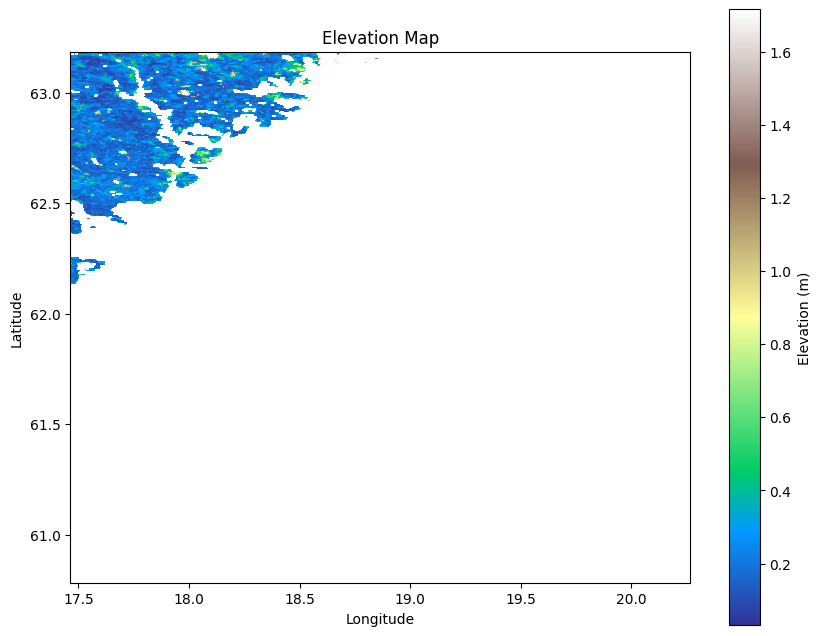

In [55]:

# Specify the path to the raster file
raster_file_path = DictFilenames[5][220]
# Open the raster file using rasterio
with rasterio.open(raster_file_path) as dataset:
    print(raster_file_path)
    # Read the raster data (assuming only one band)
    raster_data = dataset.read(1)

    # Get the spatial extent of the raster
    xmin, ymin, xmax, ymax = dataset.bounds

print(xmin, ymin, xmax, ymax)
print(np.mean(raster_data))
# Plot the raster data using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(raster_data, cmap='terrain', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(label='Elevation (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Elevation Map')
plt.show()
# 22.759947123017323 62.4860366113768

# Saving the ID, and array Position given the Band and coordinates of the raster data

In [56]:
Bounds[1]

array([[ 5.5200000e+02,  3.6958455e+06,  3.2594050e+06],
       [ 3.9600000e+02,  4.2953720e+06,  2.3605783e+05],
       [ 4.1500000e+02,  3.6958455e+06,  1.4219068e+06],
       ...,
       [ 9.4000000e+01,  6.0930255e+06,  2.2477618e+06],
       [ 3.6400000e+02,  5.0941235e+06, -7.1118500e+04],
       [ 6.1300000e+02,  6.2929450e+06, -5.6755809e+04]], dtype=float32)

In [57]:
# Apply the function to each coordinate using map and numpy.array
samplingOn_0 = np.array(list(map(lambda coord: get_tif_ArrayPosition(coord[1], coord[0], kdTrees[0], Bounds[0], DictFilenames[0], crsDataset[0], DictTransforms[0]), sampled_coordinates)))

# The result will be a numpy array where each row contains (id, x, y) for each input coordinate
print(samplingOn_0.shape)

(981333, 3)


In [58]:
samplingOn_0


array([[185., 105., 662.],
       [301., 767., 675.],
       [301., 534.,  82.],
       ...,
       [ 19.,  84., 290.],
       [  3., 696., 671.],
       [  3., 301., 899.]])

In [59]:
np.save("sampleCoordinatesElevationIDArrayPosition.npy", samplingOn_0)

In [60]:
crsDataset[1]

CRS.from_wkt('PROJCS["Sinusoidal",GEOGCS["GCS_Undefined",DATUM["Undefined",SPHEROID["User_Defined_Spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [61]:
src_crsMODIS2015

CRS.from_wkt('PROJCS["Sinusoidal",GEOGCS["GCS_Undefined",DATUM["Undefined",SPHEROID["User_Defined_Spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [62]:
i = 1
# Apply the function to each coordinate using map and numpy.array
samplingOn_1 = np.array(list(map(lambda coord: get_tif_ArrayPosition(coord[1], coord[0], kdTrees[i], Bounds[i], DictFilenames[i], crsDataset[i], DictTransforms[i]), sampled_coordinates)))

# The result will be a numpy array where each row contains (id, x, y) for each input coordinate
print(samplingOn_1.shape)

(981333, 3)


In [63]:
# Save the array to the .npy file
np.save("sampleCoordinatesMODIS2015IDArrayPosition.npy", samplingOn_1)

In [64]:

i = 2
# Apply the function to each coordinate using map and numpy.array
samplingOn_2 = np.array(list(map(lambda coord: get_tif_ArrayPosition(coord[1], coord[0], kdTrees[i], Bounds[i], DictFilenames[i], crsDataset[i], DictTransforms[i]), sampled_coordinates)))
# Zählen der Einträge, die "0, 0, 0" sind


In [ ]:
count = sum(1 for entry in samplingOn_2 if np.all(entry == [0, 0, 0]))

print(f"Anzahl der Einträge mit '0, 0, 0': {count}")
# The result will be a numpy array where each row contains (id, x, y) for each input coordinate
print(samplingOn_2.shape)

In [66]:
print(samplingOn_2)

[[127. 293. 585.]
 [127. 200. 591.]
 [127.  92. 316.]
 ...
 [129.  83. 413.]
 [ 73. 567. 189.]
 [ 73. 384. 295.]]


In [67]:
# Save the array to the .npy file
np.save("sampleCoordinatesLAIIDArrayPosition.npy", samplingOn_2)

In [68]:
i = 3
# Apply the function to each coordinate using map and numpy.array
samplingOn_3 = np.array(list(map(lambda coord: get_tif_ArrayPosition(coord[1], coord[0], kdTrees[i], Bounds[i], DictFilenames[i], crsDataset[i], DictTransforms[i]), sampled_coordinates)))

# The result will be a numpy array where each row contains (id, x, y) for each input coordinate
print(samplingOn_3.shape)

(981333, 3)


In [69]:
# Save the array to the .npy file
np.save("sampleCoordinatesLSTIDArrayPosition.npy", samplingOn_3)

In [70]:
i = 4
# Apply the function to each coordinate using map and numpy.array
samplingOn_4 = np.array(list(map(lambda coord: get_tif_ArrayPosition(coord[1], coord[0], kdTrees[i], Bounds[i], DictFilenames[i], crsDataset[i], DictTransforms[i]), sampled_coordinates)))

# The result will be a numpy array where each row contains (id, x, y) for each input coordinate
print(samplingOn_4.shape)

(981333, 3)


In [71]:

# Save the array to the .npy file
np.save("sampleCoordinatesEvapoIDArrayPosition.npy", samplingOn_4)

In [72]:
i = 5
# Apply the function to each coordinate using map and numpy.array
samplingOn_5 = np.array(list(map(lambda coord: get_tif_ArrayPosition(coord[1], coord[0], kdTrees[i], Bounds[i], DictFilenames[i], crsDataset[i], DictTransforms[i]), sampled_coordinates)))

# The result will be a numpy array where each row contains (id, x, y) for each input coordinate
print(samplingOn_5.shape)

-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
-4191.0 10421.0 0
(981333, 3)


In [73]:
np.save("sampleCoordinatesEsIDArrayPosition.npy", samplingOn_5)

In [74]:
import shutil
from google.colab import drive

def move_file_to_drive(source_file_path, destination_dir='/content/drive/MyDrive'):
    """
    Move a file from the local runtime environment in Google Colab to your Google Drive.

    Parameters:
    source_file_path (str): The path to the file you want to move.
    destination_dir (str): The destination directory in your Google Drive.

    Returns:
    None
    """

    # Move the file to your Google Drive
    shutil.move(source_file_path, destination_dir)

    print(f"File moved to Google Drive: {destination_dir}")


In [75]:
# move_file_to_drive('/content/sampleCoordinatesEsIDArrayPosition.npy')

# Make .PT files out of the Raster Data

In [76]:
import torch

def process_tif_files(input_folder_path):
    """
    Process all TIFF files in a folder, extract the integer ID from the file names,
    read the raster data, and save it as a PyTorch tensor in a .pt file.

    Parameters:
    input_folder_path (str): The path to the folder containing the TIFF files.

    Returns:
    None
    """

    # Create a new folder with the same name as the original folder appended with 'Tensor'
    output_folder_name = os.path.basename(input_folder_path) + 'Tensor'
    output_folder_path = os.path.join('/content/drive/My Drive/', output_folder_name)
    os.makedirs(output_folder_path, exist_ok=True)

    # Get a list of all TIFF files in the input folder
    tif_files = [f for f in os.listdir(input_folder_path) if f.endswith('.tif')]

    # Loop through each TIFF file
    for tif_file in tif_files:
        # Extract the integer ID from the file name using regex
        match = re.search(r'ID(\d+)_N', tif_file)
        if match:
            integer_id = int(match.group(1))

            # Form the full path of the input TIFF file
            tif_file_path = os.path.join(input_folder_path, tif_file)

            # Read the raster data using rasterio
            with rasterio.open(tif_file_path) as dataset:
                raster_data = dataset.read(1)  # Assuming there's only one band
                # Convert the raster data to a PyTorch tensor
                tensor_data = torch.tensor(float(raster_data))

                            # Save the PyTorch tensor as a .pt file with the corresponding ID inside the output folder
            output_file_path = os.path.join(output_folder_path, f'{integer_id}.pt')
            torch.save(tensor_data, output_file_path)

            print(f"File processed and saved: {output_file_path}")

# # Example usage:
# input_folder_path = '/content/SoilEvaporation_Smallv4/SoilEvaporation2015v4'
# process_tif_files(input_folder_path)


In [140]:
import os
import numpy as np
import torch
import rasterio
import re

def adjust_bounds(bounds):
    min_lon, min_lat, max_lon, max_lat = bounds
    if min_lat > max_lat:
        min_lat, max_lat = max_lat, min_lat
    if min_lon > max_lon:
        min_lon, max_lon = max_lon, min_lon
    return (min_lon, min_lat, max_lon, max_lat)

def adjust_raster_data(data, bounds):
    adjusted_data = data.copy()
    return adjusted_data

def process_folder(folder_path, mode='',suffix='_2015_Redux'):
    # Create a new folder with the same name as the original folder appended with 'Tensor'
    output_folder_name = os.path.basename(folder_path) + 'Tensor'+suffix
    output_folder_path = os.path.join('/content/', output_folder_name)
    os.makedirs(output_folder_path, exist_ok=True)

    tif_files = [file for file in os.listdir(folder_path) if file.endswith('.tif')]

    for tif_file in tif_files:
        print(tif_file)
        tif_path = os.path.join(folder_path, tif_file)
        # Extract the integer ID from the file name using regex
        match = re.search(r'ID(\d+)N', tif_file)
        integer_id = 0
        if match:
            integer_id = int(match.group(1))

            with rasterio.open(tif_path) as src:
                bounds = src.bounds
                adjusted_bounds = adjust_bounds(bounds)
                data = src.read(1)  # Read the first band of raster data

                if bounds != adjusted_bounds:
                    print(f"Adjusting bounds for {tif_file}")
                    adjusted_data = data
                else:
                    adjusted_data = data

                # Convert the adjusted data to a PyTorch tensor
                tensor_data = torch.tensor(adjusted_data.copy(), dtype=torch.float)

                # Handle non-numerical values based on the mode
                if mode == 'average':
                    mask = torch.isfinite(tensor_data)
                    avg = torch.mean(tensor_data[mask])
                    tensor_data[~mask] = avg
                elif isinstance(mode, (int, float)):
                    tensor_data[~torch.isfinite(tensor_data)] = mode
                # If mode is '', ' ', or None, do nothing (default behavior)

                # Save the tensor data as a .pt file
                pt_path = os.path.join(output_folder_path, f'{integer_id}.pt')
                torch.save(tensor_data, pt_path)
                print(f"File processed and saved: {pt_path}")
        else:
            print('ERROR')


In [141]:
process_folder('/content/SoilEvaporation_2015_Redux/SoilEvaporation','average') # needs to be changed -> average

ID120N43_12083333333334S41_32083333333333W16_166666666666664E17_966666666666665.tif
File processed and saved: /content/SoilEvaporationTensor_2015_Redux/120.pt
ID212N70_07083333333334S68_27083333333333W25_15E26_95.tif
File processed and saved: /content/SoilEvaporationTensor_2015_Redux/212.pt
ID228N64_67916666666667S62_87916666666667W8_979166666666666E10_783333333333333.tif
File processed and saved: /content/SoilEvaporationTensor_2015_Redux/228.pt
ID186N48_5125S46_70833333333333W23_354166666666668E25_15416666666667.tif
File processed and saved: /content/SoilEvaporationTensor_2015_Redux/186.pt
ID436N43_12083333333334S41_32083333333333W1_7958333333333334E3_595833333333333.tif
File processed and saved: /content/SoilEvaporationTensor_2015_Redux/436.pt
ID269N41_325S39_525W21_558333333333334E23_358333333333334.tif
File processed and saved: /content/SoilEvaporationTensor_2015_Redux/269.pt
ID13N61_0875S59_287499999999994W-1_7999999999999998E0_0.tif
File processed and saved: /content/SoilEvaporat

In [142]:
process_folder('/content/Elevation_Redux/Elevation') # the sea is at 0 -good
process_folder('/content/LAI_2015_Redux/LAI2015v2',-100) # -inf values to be changed -> -100
process_folder('/content/LST_2015_Redux/LST2015v2','average') # needs to be changed -> average
process_folder('/content/MODIS_NPP_2015_Redux/npp') # null values handled - good
process_folder('/content/TotalEvapo_2015_Redux/TotalEvapov2','average') # needs to be change  -> average

Streaming output truncated to the last 5000 lines.
ID243N73_6625S71_86458333333331W32_33749999999999E34_137499999999996.tif
File processed and saved: /content/ElevationTensor_2015_Redux/243.pt
ID149N73_6625S71_86458333333331W-12_57708333333333E-10_779166666666665.tif
File processed and saved: /content/ElevationTensor_2015_Redux/149.pt
ID345N34_13749999999999S32_33749999999999W-5_391666666666665E-3_5916666666666655.tif
File processed and saved: /content/ElevationTensor_2015_Redux/345.pt
ID505N66_47708333333333S64_67708333333331W3_591666666666666E5_391666666666666.tif
File processed and saved: /content/ElevationTensor_2015_Redux/505.pt
ID473N71_86666666666666S70_06666666666665W-1_7979166666666664E0_0020833333333333537.tif
File processed and saved: /content/ElevationTensor_2015_Redux/473.pt
ID67N62_88333333333332S61_08541666666665W-12_57708333333333E-10_779166666666665.tif
File processed and saved: /content/ElevationTensor_2015_Redux/67.pt
ID265N66_47708333333333S64_67708333333331W26_9479

In [99]:
import torch

# Load the tensor from the .pt file
file_path = '/content/LST2015v2Tensor/0.pt'
loaded_tensor = torch.load(file_path)

# Check if the tensor is of float data type
if loaded_tensor.dtype == torch.float32 or loaded_tensor.dtype == torch.float64:
    print("The loaded tensor is of float data type.")
else:
    print("The loaded tensor is not of float data type.")


The loaded tensor is of float data type.


<ipython-input-99-ef05c9af5d5f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_tensor = torch.load(file_path)


<ipython-input-119-9a32833fab4a>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_tensor = torch.load(file_path)


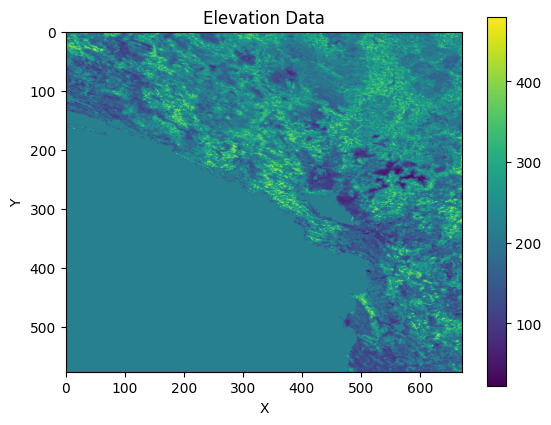

In [119]:
import torch
import matplotlib.pyplot as plt

# Load the tensor from the .pt file
file_path = '/content/TotalEvapov2Tensor/0.pt'
loaded_tensor = torch.load(file_path)

# Convert the tensor to a NumPy array
numpy_array = loaded_tensor.numpy()

# Plot the data using matplotlib
plt.imshow(numpy_array, cmap='viridis')  # You can choose the colormap you prefer
plt.colorbar()
plt.title('Elevation Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [120]:
import os

PathTensorElevation = '/content/elevationv5Tensor'
folder_name = os.path.basename(PathTensorElevation)

print(folder_name)


elevationv5Tensor


# rename Es file into new name

In [143]:
PathTensorElevation = '/content/ElevationTensor_2015_Redux'
PathTensorNpp = '/content/nppTensor_2015_Redux'
PathTensorLAI = '/content/LAI2015v2Tensor_2015_Redux'
PathTensorLST = '/content/LST2015v2Tensor_2015_Redux'
PathTensorEvapo = '/content/TotalEvapov2Tensor_2015_Redux'
PathTensorEs = '/content/SoilEvaporationTensor_2015_Redux'

PathTensor = [PathTensorElevation,PathTensorNpp,PathTensorLAI,PathTensorLST,PathTensorEvapo,PathTensorEs]

In [144]:
count_files_in_folders(Paths)
count_files_in_folders(PathTensor)

Number of files in /content/Elevation_Redux/Elevation: 646
Number of files in /content/MODIS_NPP_2015_Redux/npp: 508
Number of files in /content/LAI_2015_Redux/LAI2015v2: 304
Number of files in /content/LST_2015_Redux/LST2015v2: 493
Number of files in /content/TotalEvapo_2015_Redux/TotalEvapov2: 646
Number of files in /content/SoilEvaporation_2015_Redux/SoilEvaporation: 485
Number of files in /content/ElevationTensor_2015_Redux: 646
Number of files in /content/nppTensor_2015_Redux: 508
Number of files in /content/LAI2015v2Tensor_2015_Redux: 304
Number of files in /content/LST2015v2Tensor_2015_Redux: 493
Number of files in /content/TotalEvapov2Tensor_2015_Redux: 646
Number of files in /content/SoilEvaporationTensor_2015_Redux: 485


In [145]:
import shutil

In [146]:
# Root directory in Google Drive to save the ZIP files
drive_folder = '/content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/TensorFilesRaster/'
os.makedirs(drive_folder, exist_ok=True)

def zip_and_download_folder(folder_path):
    output_filename = os.path.basename(folder_path)
    shutil.make_archive(output_filename, 'zip', folder_path)
    shutil.move(f"{output_filename}.zip", drive_folder + f"{output_filename}.zip")

for path in PathTensor:
  zip_and_download_folder(path)



# Save the frameworks using Dask

In [125]:
drive_folder = '/content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/CoordinatesPoints/'

In [126]:
import dask.dataframe as dd
import dask.array as da


def save_numpy_array_to_parquet(numpy_array, output_file_name, output_location):
    """
    Convert the NumPy array to a Dask DataFrame and save it as a Parquet file.

    Parameters:
    numpy_array (numpy.ndarray): The NumPy array to be saved as a Dask DataFrame.
    output_file_name (str): The name of the output file (without file extension).
    output_location (str): The directory path where the Parquet file will be saved.

    Returns:
    None
    """
    # Create the full path for the output .npy file
    output_npy_file = f"{output_location}/{output_file_name}.npy"

    # Save the NumPy array as a .npy file
    np.save(output_npy_file, numpy_array)
    print(f"NumPy array saved as .npy file: {output_npy_file}")


# Create a NumPy array (replace this with your actual NumPy array)
numpy_array = np.array([[1, 2], [3, 4], [5, 6]])




In [127]:
samplingOn_0

array([[185., 105., 662.],
       [301., 767., 675.],
       [301., 534.,  82.],
       ...,
       [ 19.,  84., 290.],
       [  3., 696., 671.],
       [  3., 301., 899.]])

In [128]:
# Call the function to save the numpy array as a Parquet file
dask_df = save_numpy_array_to_parquet(samplingOn_0, 'sampleCoordinatesElevationIDArrayPosition', drive_folder)
save_numpy_array_to_parquet(samplingOn_1, 'sampleCoordinatesMODIS2015NPPIDArrayPosition_Redux', drive_folder)
save_numpy_array_to_parquet(samplingOn_2, 'sampleCoordinatesLAIIDArrayPosition', drive_folder)
save_numpy_array_to_parquet(samplingOn_3, 'sampleCoordinatesLSTIDArrayPosition', drive_folder)
save_numpy_array_to_parquet(samplingOn_4, 'sampleCoordinatesEvapoIDArrayPosition', drive_folder)


NumPy array saved as .npy file: /content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/CoordinatesPoints//sampleCoordinatesElevationIDArrayPosition.npy
NumPy array saved as .npy file: /content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/CoordinatesPoints//sampleCoordinatesMODIS2015NPPIDArrayPosition_Redux.npy
NumPy array saved as .npy file: /content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/CoordinatesPoints//sampleCoordinatesLAIIDArrayPosition.npy
NumPy array saved as .npy file: /content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/CoordinatesPoints//sampleCoordinatesLSTIDArrayPosition.npy
NumPy array saved as .npy file: /content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/CoordinatesPoints//sampleCoordinatesEvapoIDArrayPosition.npy


In [129]:
save_numpy_array_to_parquet(samplingOn_5, 'sampleCoordinatesEsIDArrayPosition', drive_folder)


NumPy array saved as .npy file: /content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/CoordinatesPoints//sampleCoordinatesEsIDArrayPosition.npy


In [130]:
dask_df

# Dask

In [131]:
import numpy as np
import dask.dataframe as dd
import dask.array as da

def create_dask_dataframe_with_strings(numpy_array):
    """
    Create a Dask DataFrame from a NumPy array with integer elements,
    transforming the first column into strings.

    Parameters:
    numpy_array (numpy.ndarray): The NumPy array to be converted.

    Returns:
    dask.dataframe.DataFrame: The Dask DataFrame with columns 'id', 'x', and 'y'.
    """
    # we tranform the array into a integer
    numpy_array = numpy_array.astype(int)
    # Convert the first column to strings

    # Define column names
    column_names = ['ID', 'x', 'y']

    # Create the Dask DataFrame
    stacked_dask_array = da.stack([numpy_array[:, 0], numpy_array[:, 1], numpy_array[:, 2]]).T
    print(stacked_dask_array.shape)
    dask_df = dd.from_array(stacked_dask_array, columns=column_names)
    # Transform the 'ID' column from int to str
    dask_df['ID'] = dask_df['ID'].astype(str)


    return dask_df.compute()



In [132]:

sampleCoordinatesElevationIDArrayPositionDf = create_dask_dataframe_with_strings(samplingOn_0)
sampleCoordinatesNppIDArrayPositionDf = create_dask_dataframe_with_strings(samplingOn_1)
sampleCoordinatesLAIIDArrayPositionDf = create_dask_dataframe_with_strings(samplingOn_2)
sampleCoordinatesLSTIDArrayPositionDf = create_dask_dataframe_with_strings(samplingOn_3)
sampleCoordinatesEvapoIDArrayPositionDf = create_dask_dataframe_with_strings(samplingOn_4)


(981333, 3)
(981333, 3)
(981333, 3)
(981333, 3)
(981333, 3)


In [133]:
sampleCoordinatesEsIDArrayPositionDf = create_dask_dataframe_with_strings(samplingOn_5)


(981333, 3)


In [134]:
# Save the Dask DataFrame as a Parquet file
import shutil
destination_drive_directory = '/content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/CoordinatesPoints/'

output_parquet_file = '/content/sampleCoordinatesElevationIDArrayPositionDf_Redux.parquet'
sampleCoordinatesElevationIDArrayPositionDf.to_parquet(output_parquet_file)
shutil.move(output_parquet_file, destination_drive_directory)

output_parquet_file = '/content/sampleCoordinatesEvapoIDArrayPositionDf_Redux.parquet'
sampleCoordinatesEvapoIDArrayPositionDf.to_parquet(output_parquet_file)
shutil.move(output_parquet_file, destination_drive_directory)

output_parquet_file = '/content/sampleCoordinatesLAIIDArrayPositionDf_Redux.parquet'
sampleCoordinatesLAIIDArrayPositionDf.to_parquet(output_parquet_file)
shutil.move(output_parquet_file, destination_drive_directory)

output_parquet_file = '/content/sampleCoordinatesLSTIDArrayPositionDf_Redux.parquet'
sampleCoordinatesLSTIDArrayPositionDf.to_parquet(output_parquet_file)
shutil.move(output_parquet_file, destination_drive_directory)

output_parquet_file = '/content/sampleCoordinatesMODIS2015NPPIDArrayPosition_Redux.parquet'
sampleCoordinatesNppIDArrayPositionDf.to_parquet(output_parquet_file)
shutil.move(output_parquet_file, destination_drive_directory)

Error: Destination path '/content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/CoordinatesPoints/sampleCoordinatesElevationIDArrayPositionDf_Redux.parquet' already exists

In [ ]:

output_parquet_file = '/content/sampleCoordinatesEsIDArrayPositionDf_Redux.parquet'
sampleCoordinatesEsIDArrayPositionDf.to_parquet(output_parquet_file)
shutil.move(output_parquet_file, destination_drive_directory)